## Programming Problem: Comparing SARSA and Q-Learning on $10\times 10$ Gridworld (10 pts)

In this problem, you will implement and compare two temporal-difference reinforcement learning algorithms:

- SARSA (On-policy TD(0))
- Q-Learning (Off-policy TD(0))

You will test them on a $10\times 10$ Gridworld with obstacles and a goal.

---

###  Environment Description

- **Grid size**: $10\times 10$ (states indexed by (row, col))
- **Actions**: {up, down, left, right}
- **Transition**: deterministic, constrained by grid boundaries
- **Rewards**:
    - Reaching the **goal state** (red `G`): **+10**, then episode ends
    - Stepping into an **obstacle** (green `O`): **-10**, and the agent remains in the obstacle
    - All other steps: **0**
- **Goal state behavior**:
    - It is **terminal and absorbing**: after entering the goal, any action returns the agent to the goal state with **reward 0**
- **Start state**: always starts at $(0, 0)$
- **Discount factor**: $\gamma = 0.99$

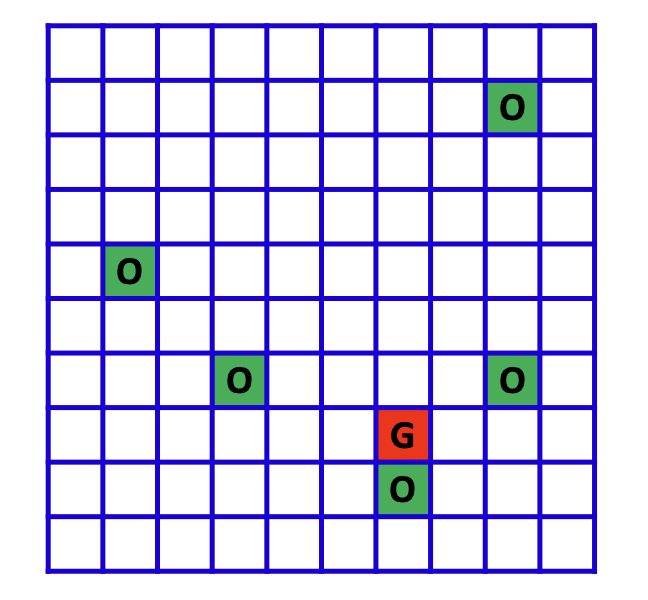

---

### Task : Compare Convergence

1. Implement **SARSA** and **Q-learning** using an $\epsilon$-greedy policy with $\epsilon = 0.1$ or $0.5$.
2. Randomly select **10 distinct non-terminal, non-obstacle states** from the grid.
3. During training, track the **value estimate** at each selected state:
   - Define the state value as $V(s) = \max_a Q(s, a)$.
4. For each algorithm, plot the **sum of the values** at the 10 selected states over episodes and compare the convergence rate.

##### Set up the Grid Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class GridEnv:
    def __init__(self):
        self.n_rows = 10
        self.n_cols = 10
        self.n_states = self.n_rows * self.n_cols
        self.n_actions = 4
        self.gamma = 0.99

        self.obstacles = {(1, 8), (4, 1), (6, 3), (6, 8), (8, 6)}
        self.goal = (7, 6)
        self.start = (0, 0)
        self.state = self.start


    def encode(self, r, c):
        return r * self.n_cols + c


    def reset(self):
        self.state = self.start
        return self.encode(*self.state)


    def step(self, a):
        r, c = self.state

        if (r, c) == self.goal:
            return self.encode(r, c), 0.0, True

        new_r, new_c = r, c
        if a == 0:      # up
            new_r = max(0, r - 1)
        elif a == 1:    # down
            new_r = min(self.n_rows - 1, r + 1)
        elif a == 2:    # left
            new_c = max(0, c - 1)
        elif a == 3:    # right
            new_c = min(self.n_cols - 1, c + 1)

        self.state = (new_r, new_c)

        if self.state == self.goal:
            return self.encode(new_r, new_c), 10.0, True

        if self.state in self.obstacles:
            return self.encode(new_r, new_c), -10.0, False

        return self.encode(new_r, new_c), 0.0, False

##### SARSA and Q-learning algorithms

In [2]:
def epsilon_greedy_action(Q, s, epsilon, rng):
    if rng.random() < epsilon:
        return int(rng.integers(Q.shape[1]))
    best = np.max(Q[s])
    candidates = np.flatnonzero(Q[s] == best)
    return int(rng.choice(candidates))


def sample_10_states(env, rng):
    valid = []
    for r in range(env.n_rows):
        for c in range(env.n_cols):
            if (r, c) == env.goal:
                continue
            if (r, c) in env.obstacles:
                continue
            valid.append(env.encode(r, c))
    valid = np.array(valid, dtype=int)
    return rng.choice(valid, size=10, replace=False)


def sum_values_over_states(Q, states):
    return float(np.sum(np.max(Q[states], axis=1)))


def calc_V(env, Q):
    V = np.max(Q, axis=1)

    for (r, c) in env.obstacles:
        s = env.encode(r, c)
        V[s] = -10.0

    r, c = env.goal
    s = env.encode(r, c)
    V[s] = 10.0

    return V


def SARSA(env, episodes, alpha, epsilon, track_states, seed):
    rng = np.random.default_rng(seed)
    Q = np.zeros((env.n_states, env.n_actions), dtype=float)
    curve = np.zeros(episodes, dtype=float)

    for ep in range(episodes):
        s = env.reset()
        a = epsilon_greedy_action(Q, s, epsilon, rng)

        while True:
            s2, r, done = env.step(a)
            a2 = epsilon_greedy_action(Q, s2, epsilon, rng)

            td_target = r + env.gamma * (0.0 if done else Q[s2, a2])
            Q[s, a] += alpha * (td_target - Q[s, a])

            s, a = s2, a2
            if done:
                break

        curve[ep] = sum_values_over_states(Q, track_states)

    return calc_V(env, Q), curve



def Q_Learning(env, episodes, alpha, epsilon, max_steps, track_states, seed):
    rng = np.random.default_rng(seed)
    Q = np.zeros((env.n_states, env.n_actions), dtype=float)
    curve = np.zeros(episodes, dtype=float)

    for ep in range(episodes):
        s = env.reset()

        for _ in range(max_steps):
            a = epsilon_greedy_action(Q, s, epsilon, rng)
            s2, r, done = env.step(a)

            td_target = r + env.gamma * (0.0 if done else np.max(Q[s2]))
            Q[s, a] += alpha * (td_target - Q[s, a])

            s = s2
            if done:
                break

        curve[ep] = sum_values_over_states(Q, track_states)

    return calc_V(env, Q), curve

##### Run the algotihms and visualize the results

In [3]:
episodes = 3000
max_steps = 500
seed = 0
alpha = 0.2
env = GridEnv()
rng = np.random.default_rng(seed)
track_states = sample_10_states(env, rng)


SARSA_V_01, SARSA_curve_01 = SARSA(env, episodes, alpha, 0.1, track_states, seed=seed)
SARSA_V_05, SARSA_curve_05 = SARSA(env, episodes, alpha, 0.5, track_states, seed=seed)
QLearning_V_01, QLearning_curve_01 = Q_Learning(env, episodes, alpha, 0.1, max_steps, track_states, seed=seed)
QLearning_V_05, QLearning_curve_05 = Q_Learning(env, episodes, alpha, 0.5, max_steps, track_states, seed=seed)

##### Code for visualization

In [4]:
def plot_policy(env, algorithm, epsilon, V):
    R, C = env.n_rows, env.n_cols
    A = 4

    # action: 0 up, 1 down, 2 left, 3 right  (dr, dc)
    action_drc = {
        0: (-1, 0),  # up
        1: ( 1, 0),  # down
        2: ( 0,-1),  # left
        3: ( 0, 1),  # right
    }

    fig, ax = plt.subplots(figsize=(C * 1.1, R * 1.1))
    ax.set_xlim(0, C); ax.set_ylim(0, R); ax.axis("off")

    # grid lines
    for x in range(C + 1):
        ax.plot([x, x], [0, R], color="black", lw=1.5)
    for y in range(R + 1):
        ax.plot([0, C], [y, y], color="black", lw=1.5)

    # arrows (draw all greedy ties within epsilon)
    arrow_scale = 0.40
    for r in range(R):
        for c in range(C):
            if (r, c) in env.obstacles or (r, c) == env.goal:
                continue

            s = env.encode(r, c)

            # Find neighbors and their V values
            neighbors = []
            for a in range(A):
                # Calculate next state based on action
                dr, dc = action_drc[a]
                nr, nc = r + dr, c + dc
                if 0 <= nr < R and 0 <= nc < C and (nr, nc) not in env.obstacles:
                    ns = env.encode(nr, nc)
                    neighbors.append((a, ns, V[ns]))  # store action, neighbor state, and V value

            # Find the neighbors with the max V value
            max_v = max(neighbors, key=lambda x: x[2])[2]  # Get max V value among neighbors
            best_actions = [a for a, ns, v_val in neighbors if v_val == max_v]  # Select actions that lead to max V

            # coordinate system: y=0 at bottom, so invert row index
            cx, cy = c + 0.5, R - r - 0.5

            for a in best_actions:
                dr, dc = action_drc[a]
                dx = dc * arrow_scale
                dy = -dr * arrow_scale
                ax.arrow(cx, cy, dx, dy, head_width=0.12, head_length=0.12, length_includes_head=True, fc="black", ec="black", lw=1.25)

    # mark special cells (optional but matches your env)
    for (r, c) in env.obstacles:
        ax.text(c + 0.5, R - r - 0.5, "O", ha="center", va="center", fontsize=16, fontweight="bold")
    gr, gc = env.goal
    ax.text(gc + 0.5, R - gr - 0.5, "G", ha="center", va="center", fontsize=16, fontweight="bold")
    sr, sc = env.start
    ax.text(sc + 0.15, R - sr - 0.15, "S", ha="left", va="top", fontsize=12, fontweight="bold")

    ax.set_title(rf"{algorithm} greedy policy ($\epsilon$={epsilon})", fontsize=16, pad=12)
    plt.tight_layout()
    plt.show()


def plot_convergence_curves(sarsa_eps1, sarsa_eps2, qlearning_eps1, qlearning_eps2):
    plt.figure(figsize=(10, 6))

    plt.plot(sarsa_eps1, label=r"SARSA ($\epsilon=0.1$)")
    plt.plot(sarsa_eps2, label=r"SARSA ($\epsilon=0.5$)")

    plt.plot(qlearning_eps1, label=r"Q-Learning ($\epsilon=0.1$)")
    plt.plot(qlearning_eps2, label=r"Q-Learning ($\epsilon=0.5$)")

    plt.xlabel("Episode")
    plt.ylabel("Sum of values over tracked states")
    plt.title(r"Convergence comparison under different $\epsilon$ and algorithms")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_value_table(env, algorithm, epsilon, V, decimals=1):
    R, C = env.n_rows, env.n_cols
    A = 4

    if V.ndim != 1 or len(V) != env.n_states:
        raise ValueError(f"V must be shape [n_states], got {V.shape}")

    fig, ax = plt.subplots(figsize=(C * 1.1, R * 1.1))
    ax.set_xlim(0, C); ax.set_ylim(0, R); ax.axis("off")

    # grid lines
    for x in range(C + 1):
        ax.plot([x, x], [0, R], color="black", lw=1.5)
    for y in range(R + 1):
        ax.plot([0, C], [y, y], color="black", lw=1.5)

    # fill each cell with V(s)
    for r in range(R):
        for c in range(C):
            # coordinate system: y=0 at bottom, so invert row index
            cx, cy = c + 0.5, R - r - 0.5

            if (r, c) in env.obstacles:
                ax.text(cx, cy, "O", ha="center", va="center", fontsize=16, fontweight="bold")
                continue

            if (r, c) == env.goal:
                ax.text(cx, cy, "G", ha="center", va="center", fontsize=16, fontweight="bold")
                continue

            s = env.encode(r, c)

            v = V[s]
            ax.text(cx, cy, f"{v:.{decimals}f}", ha="center", va="center", fontsize=13)

    # mark start
    sr, sc = env.start
    ax.text(sc + 0.15, R - sr - 0.15, "S", ha="left", va="top", fontsize=12, fontweight="bold")

    ax.set_title(rf"{algorithm} Value Fuction $V(s)$ Table ($\epsilon={epsilon}$)", fontsize=16, pad=12)
    plt.tight_layout()
    plt.show()

##### Visualize the results

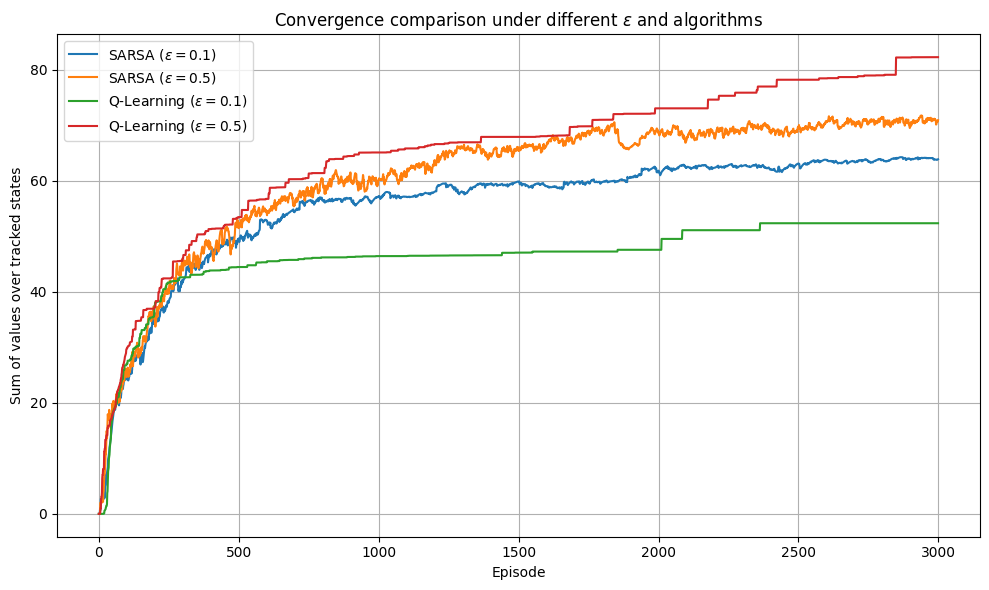

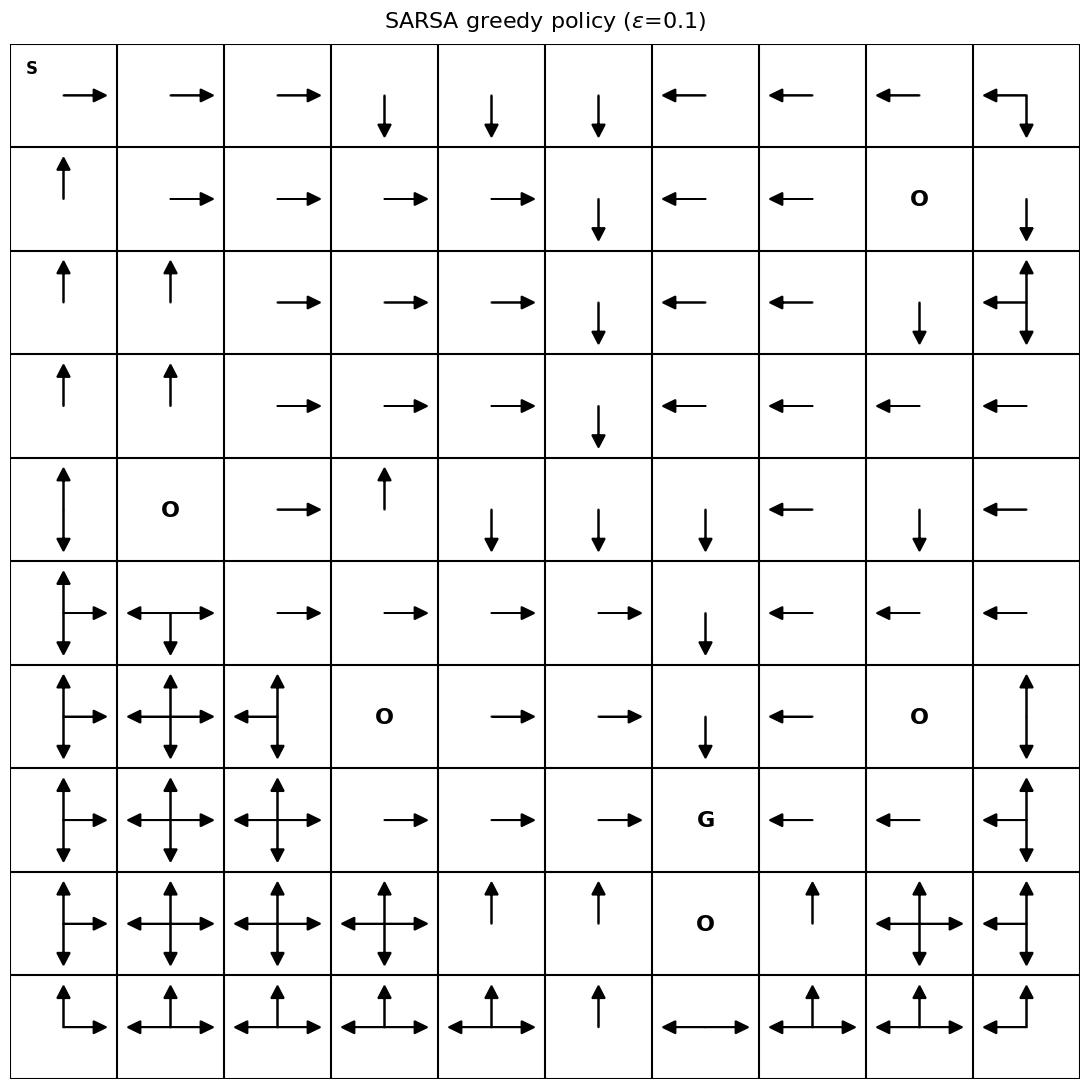

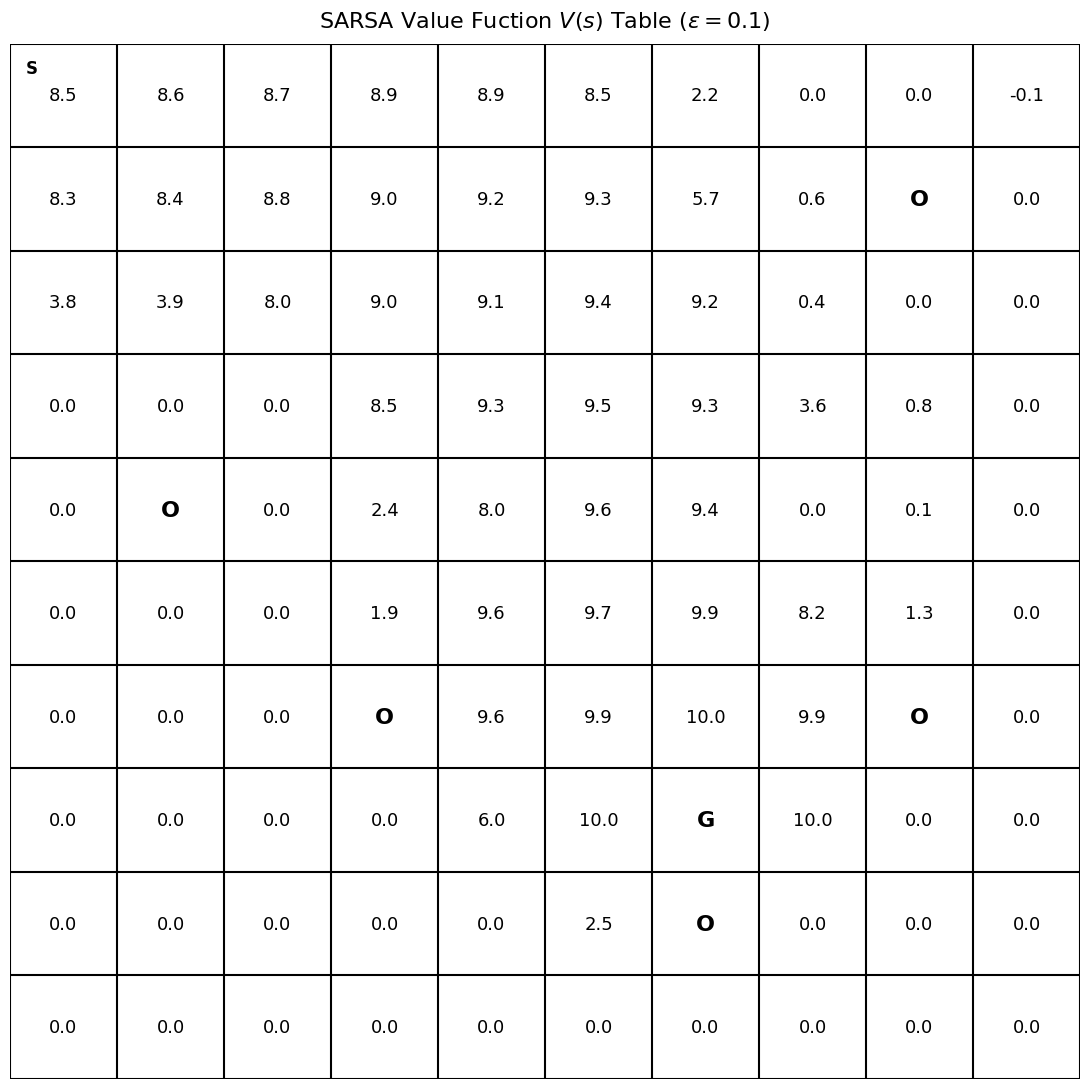

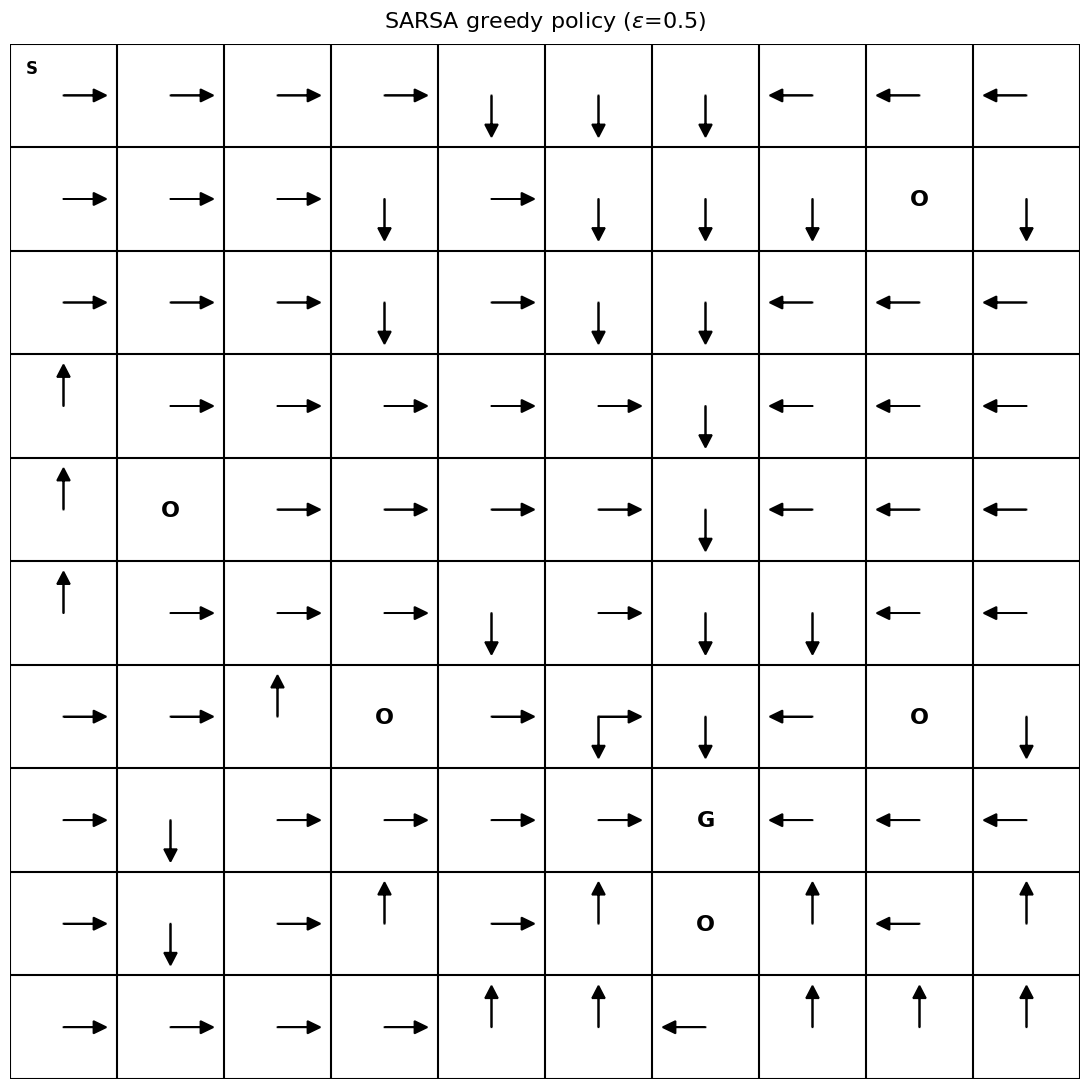

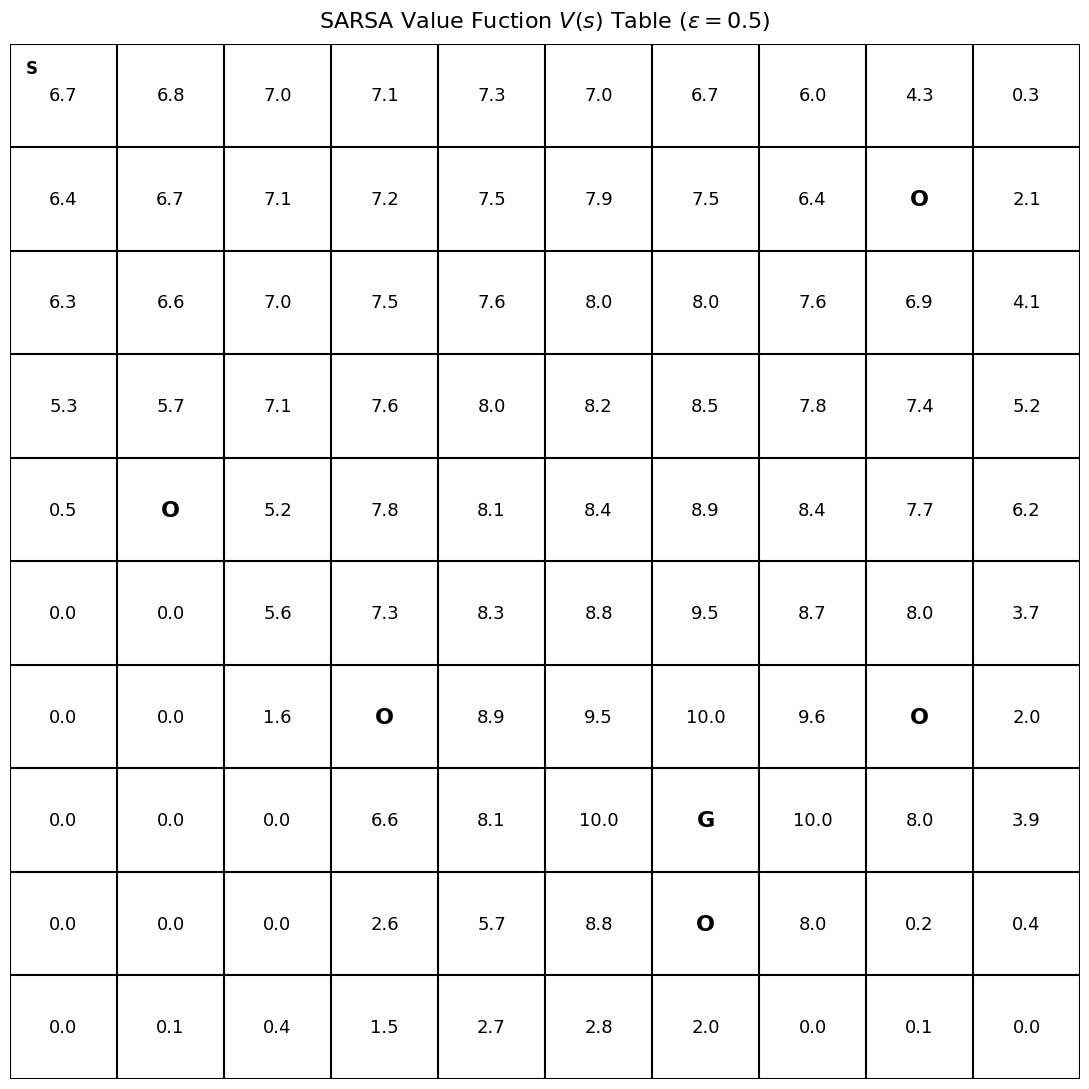

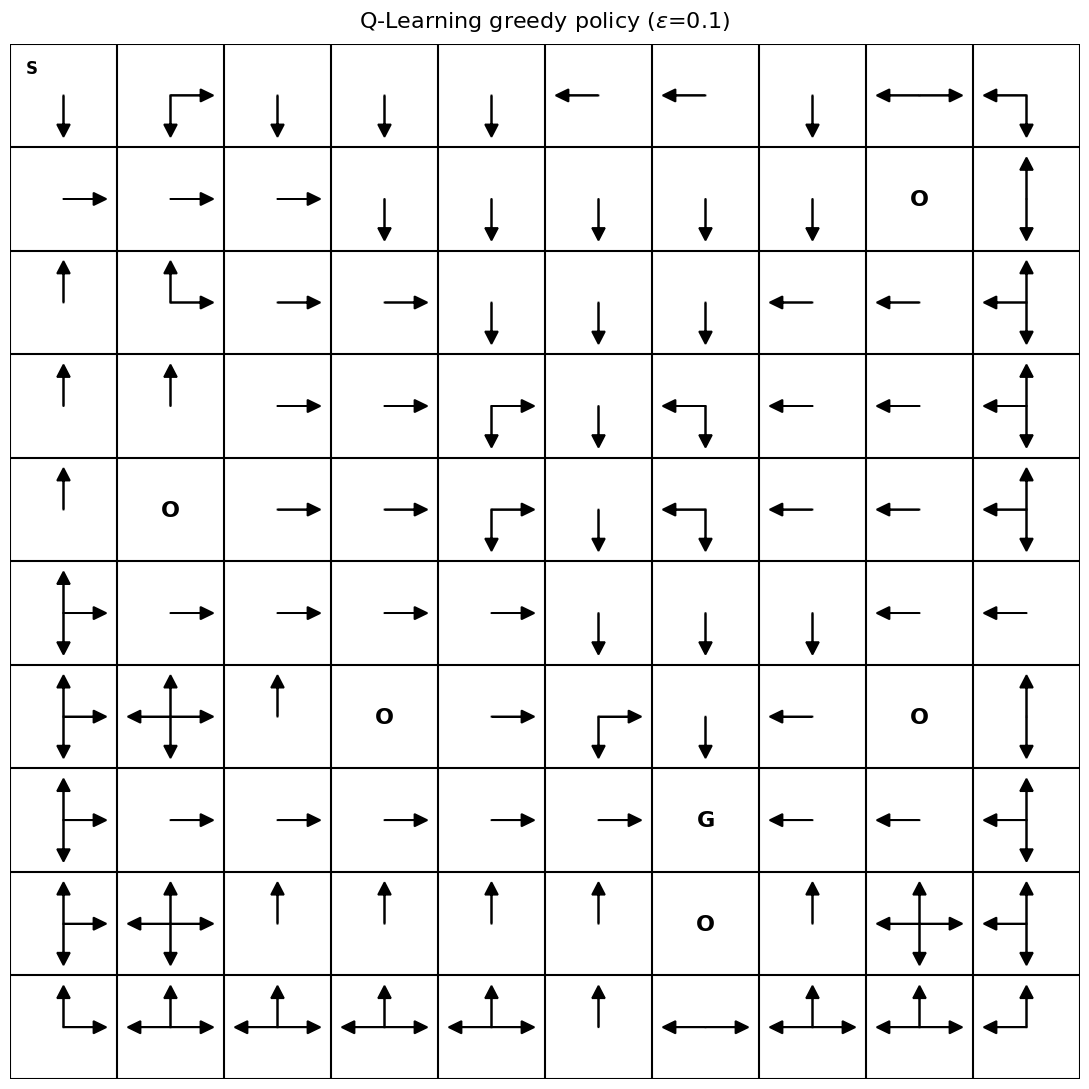

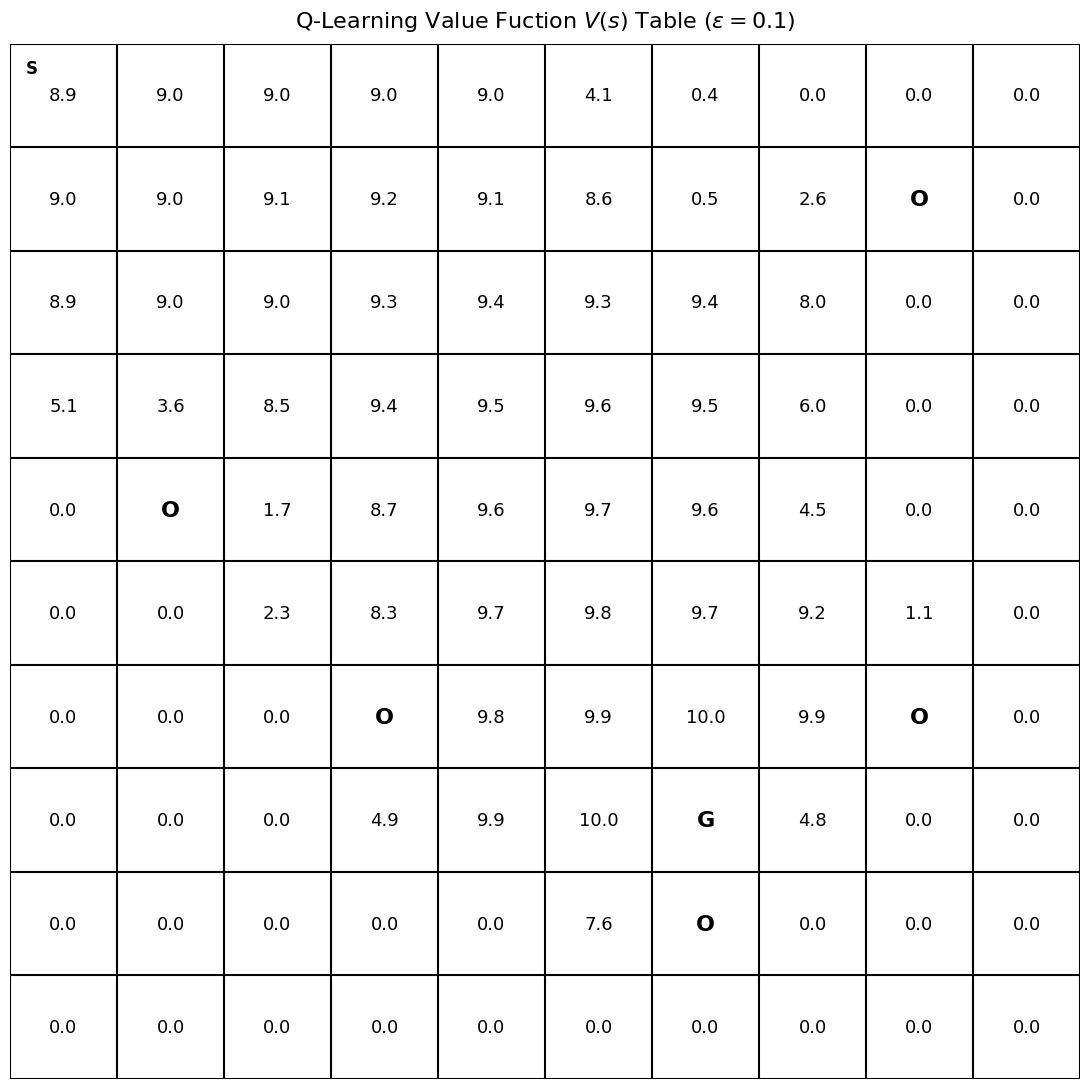

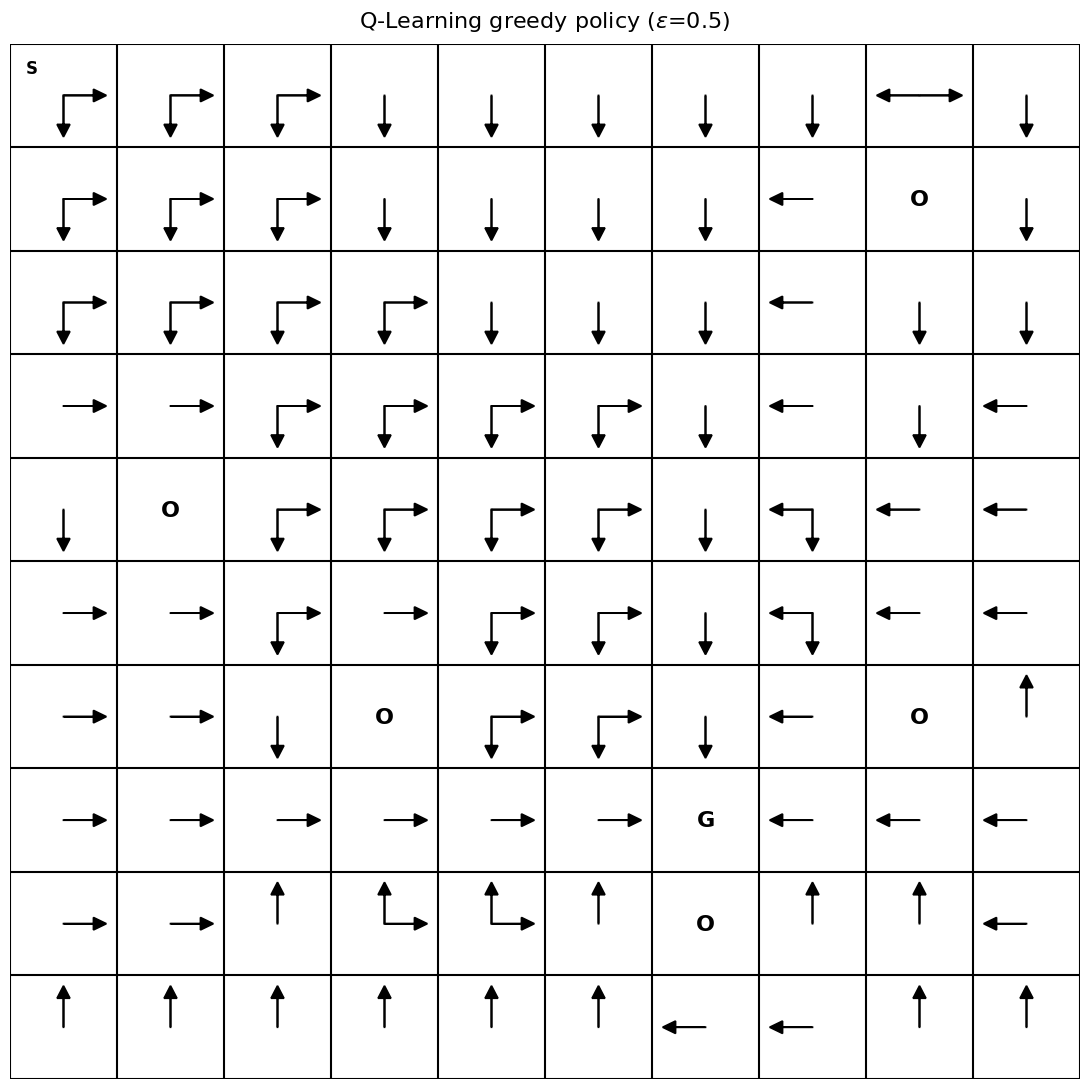

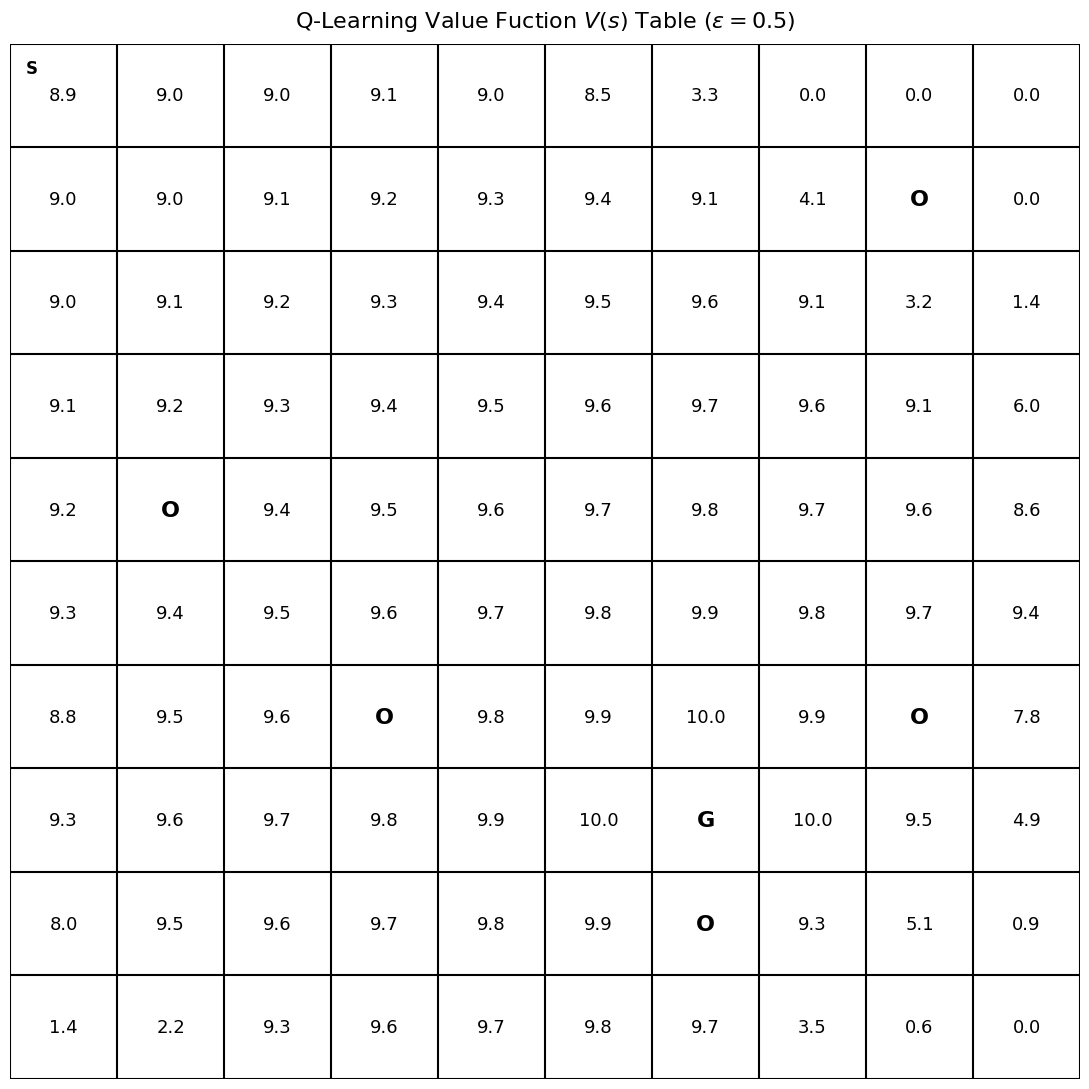

In [5]:
plot_convergence_curves(SARSA_curve_01, SARSA_curve_05, QLearning_curve_01, QLearning_curve_05)

plot_policy(env, "SARSA", 0.1, SARSA_V_01)
plot_value_table(env, "SARSA", 0.1, SARSA_V_01)

plot_policy(env, "SARSA", 0.5, SARSA_V_05)
plot_value_table(env, "SARSA", 0.5, SARSA_V_05)

plot_policy(env, "Q-Learning", 0.1, QLearning_V_01)
plot_value_table(env, "Q-Learning", 0.1, QLearning_V_01)

plot_policy(env, "Q-Learning", 0.5, QLearning_V_05)
plot_value_table(env, "Q-Learning", 0.5, QLearning_V_05)